In [1]:
import sys

python_path = ['/home/claudio/.local/lib64/python3.6/site-packages','/home/sebastian/.local/lib64/python3.6/site-packages','/home/sebastian/.local/lib/python3.6/site-packages','/home/sebastian/.local/lib/python3.6/site-packages/opencv-4.1.0-py3.6.egg/cv2',
               '/home/sebastian/.local/lib/python3.6/site-packages/cv2','/home/sebastian/dat/onnx/onnx-tensorrt/third_party/onnx']
sys.path.extend(python_path)
%matplotlib inline

In [13]:
from attention_model import *
from utils import *
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

multilabel_data = get_data_multilabel()

multilabel_data.shape

test_data = get_data(False)

device = 'cuda:1'

guestroom_model = AttentionModel.load_model(device, 'models/guest_room/')

bathroom_model = AttentionModel.load_model(device, 'models/bathroom/')

kitchen_model = AttentionModel.load_model(device, 'models/kitchen/')

livingroom_model = AttentionModel.load_model(device, 'models/living_room/')

beach_model = AttentionModel.load_model(device, 'models/beach/')

pool_model = AttentionModel.load_model(device, 'models/pool_view/')

hotel_front_model = AttentionModel.load_model(device, 'models/hotel_front/')

natural_view_model = AttentionModel.load_model(device, 'models/natural_view/')

models = {}
models['guest_room'] = guestroom_model
models['bathroom'] = bathroom_model
models['kitchen'] = kitchen_model
models['living_room'] = livingroom_model
models['beach'] = beach_model
models['pool_view'] = pool_model
models['hotel_front'] = hotel_front_model
models['natural_view'] = natural_view_model

label = 'bathroom'
batch_size = 32

test_dataset = MultitagDataset('/data/hotel_images/', test_data, label)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_dataset_without_normalization = MultitagDataset('/data/hotel_images/', multilabel_data, label, transform=image_transformations)
test_dataloader_without_normalization = DataLoader(test_dataset_without_normalization, batch_size = batch_size, shuffle = False)
multilabel_dataset = MultitagDataset('/data/hotel_images/', multilabel_data, label)
multilabel_dataloader = DataLoader(multilabel_dataset, batch_size = batch_size, shuffle = False)


In [18]:
images_list = []

for imgs, labels in test_dataloader_without_normalization:
    images_list.append(imgs)

multilabel_images = torch.cat(images_list).to(device)

In [19]:
multilabel_images.shape

torch.Size([202, 3, 448, 448])

In [20]:
with torch.no_grad():

    for k in models.keys():
        
        model = models[k]
        model.eval_mode()
        
        y_pred = []
        
        for images, labels in multilabel_dataloader:
            
            probs, _ = model.forward(images.to(device), eval_mode=True)
            pred = probs > 0.5
            pred = pred.float().T.detach().cpu().numpy().ravel()
            labels = labels.float().detach().cpu().numpy().ravel()

            y_pred.extend(pred.tolist())
            
        multilabel_data['pred_' + k] = y_pred


/home/claudio/.local/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


In [21]:
multilabel_data.to_pickle('binary_predictions.pkl')

In [ ]:
multilabel_dat[multilabel_dat]

In [22]:
model.eval_mode()

with torch.no_grad():
    
    crops = {}
    
    for k in models.keys():
        model = models[k]
        model.eval_mode()
        boxes_list = []
        
        for images, labels in multilabel_dataloader:
            attention_maps, attention_crops, ideal_attention_maps, max_centers, boxes = model.get_crops_forward(images.to(device))
            boxes_list.append(boxes)
        
        att_crops = {}
        
        att1_boxes = torch.cat([m['att1'] for m in boxes_list]).to(device)
        att2_boxes = torch.cat([m['att2'] for m in boxes_list]).to(device)
        att3_boxes = torch.cat([m['att3'] for m in boxes_list]).to(device)
        att4_boxes = torch.cat([m['att4'] for m in boxes_list]).to(device)
        
        att_crops['att1'] = model.take_crops(att1_boxes, multilabel_images)
        att_crops['att2'] = model.take_crops(att2_boxes, multilabel_images)
        att_crops['att3'] = model.take_crops(att3_boxes, multilabel_images)
        att_crops['att4'] = model.take_crops(att4_boxes, multilabel_images)
        
        crops[k] = att_crops

In [23]:
multilabel_dat = multilabel_data.reset_index()

In [64]:
bathroom_guestroom = multilabel_dat[(multilabel_dat.bathroom == 1) & (multilabel_dat.guest_room == 1)]

indices = bathroom_guestroom.index.values

crops_bathroom_att1 = crops['bathroom']['att1'][indices]
crops_bathroom_att2 = crops['bathroom']['att2'][indices]
crops_bathroom_att3 = crops['bathroom']['att3'][indices]
crops_bathroom_att4 = crops['bathroom']['att4'][indices]

crops_guestroom_att1 = crops['guest_room']['att1'][indices]
crops_guestroom_att2 = crops['guest_room']['att2'][indices]
crops_guestroom_att3 = crops['guest_room']['att3'][indices]
crops_guestroom_att4 = crops['guest_room']['att4'][indices]

images = multilabel_images[indices]

In [34]:
to_pil = transforms.ToPILImage(mode='RGB')

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

In [31]:
def plot_crops(idx, crops_c1, crops_c2, idx1, idx2):
    im1 = to_pil(crops_c1[idx1[0]][idx].cpu())
    im2 = to_pil(crops_c1[idx1[1]][idx].cpu())
    im3 = to_pil(crops_c2[idx2[0]][idx].cpu())
    im4 = to_pil(crops_c2[idx2[1]][idx].cpu())
    
    fig = plt.figure(figsize=(7., 7.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
    for ax, im in zip(grid, [im1, im2, im3, im4]):
    # Iterating over the grid returns the Axes.
        ax.imshow(im)

    plt.show()

In [32]:
def plot_attention(idx, crops_c1, crops_c2, idx1, idx2):
    plt.imshow(to_pil(images[idx].to('cpu')))
    plot_crops(idx, crops_c1, crops_c2, idx1, idx2)

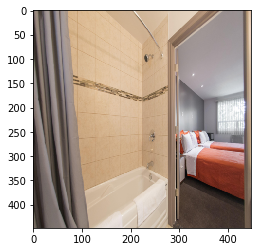

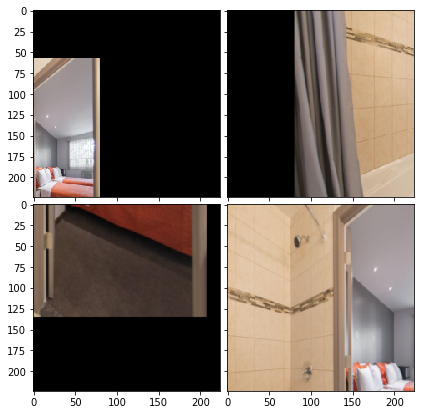

In [40]:
plot_attention(4)

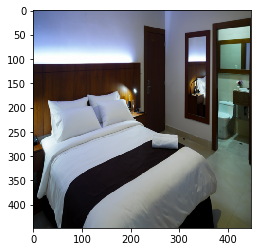

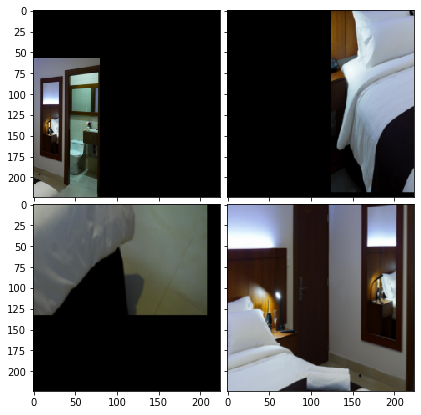

In [41]:
plot_attention(5)

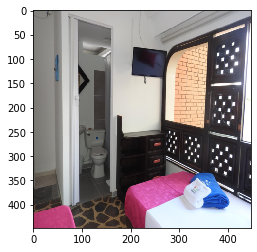

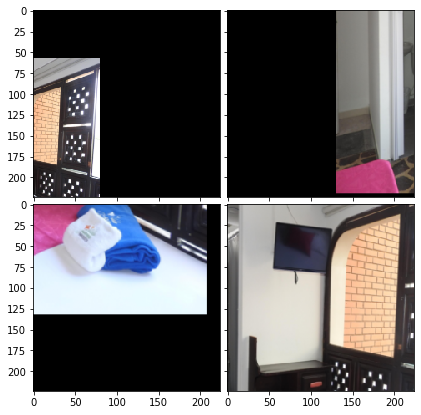

In [42]:
plot_attention(6)

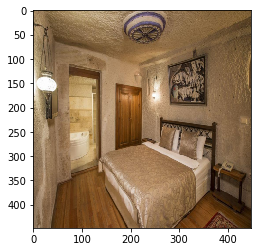

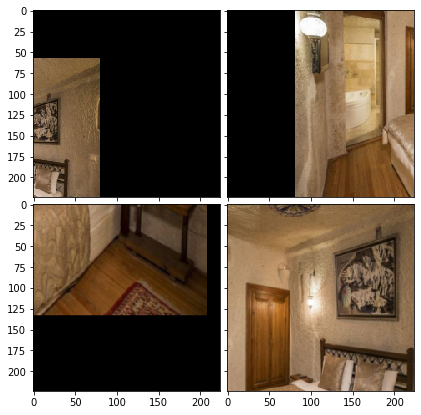

In [44]:
plot_attention(9)

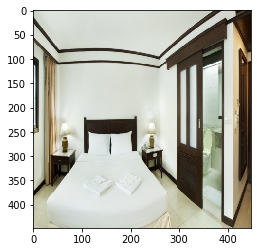

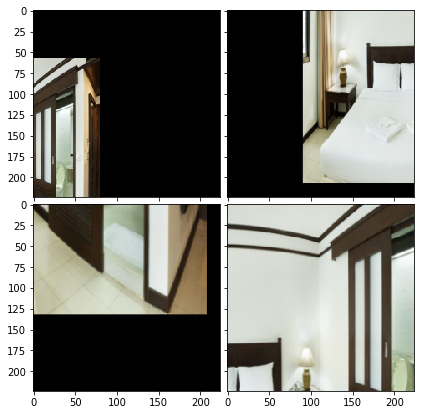

In [49]:
plot_attention(12)

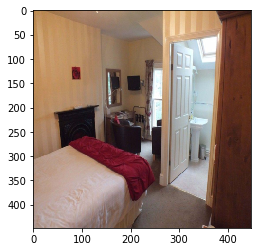

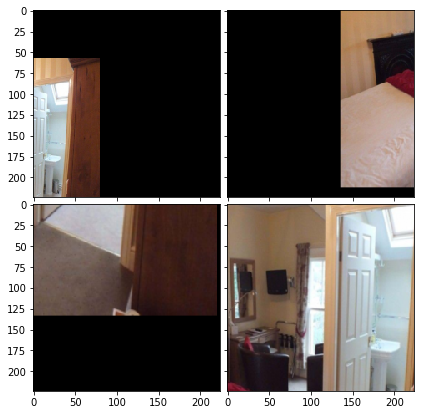

In [50]:
plot_attention(21)

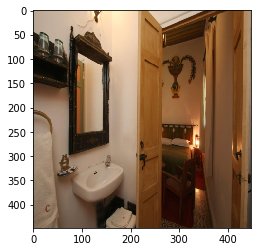

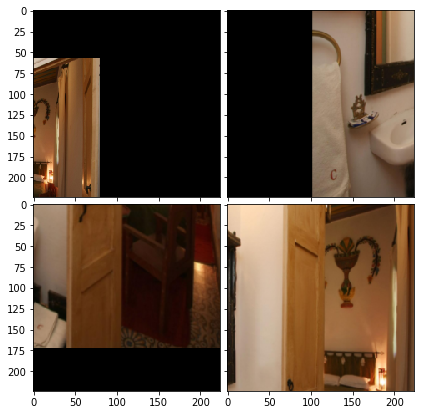

In [51]:
plot_attention(23)

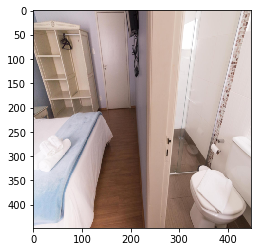

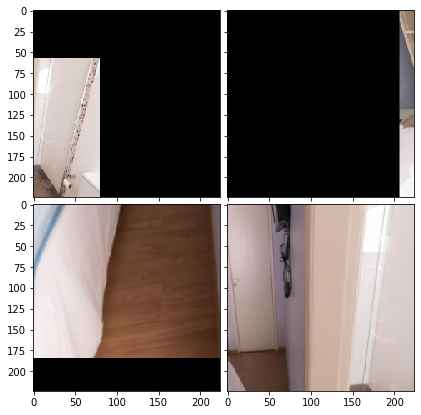

In [52]:
plot_attention(26)

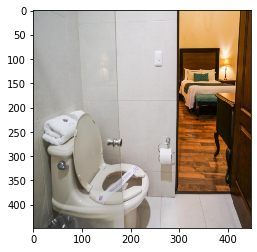

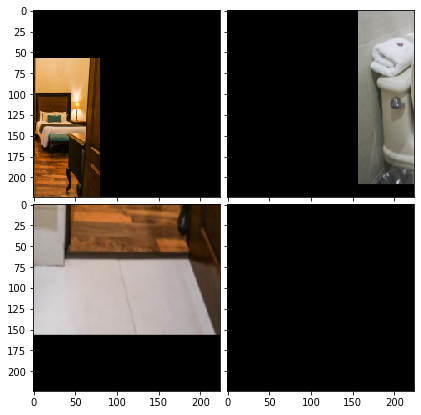

In [53]:
plot_attention(28)

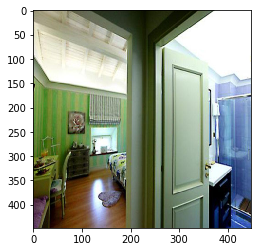

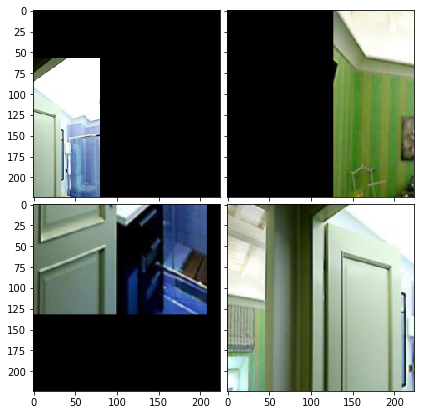

In [54]:
plot_attention(27)

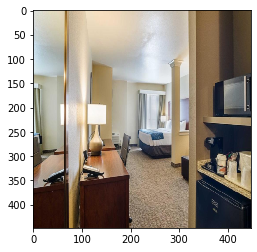

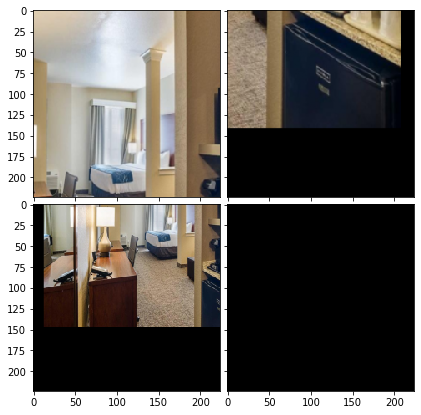

In [67]:
plot_attention(1, crops_c1, crops_c2, (2,1), (2,3))

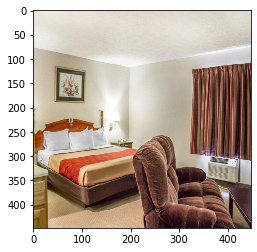

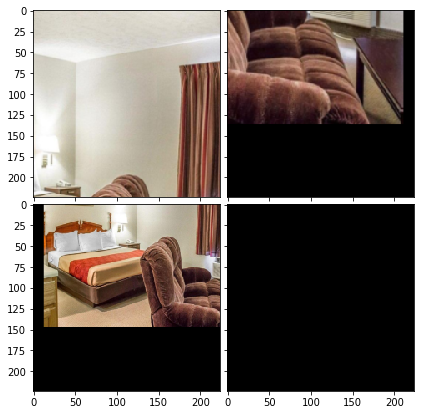

In [68]:
plot_attention(2, crops_c1, crops_c2, (2,1), (2,3))

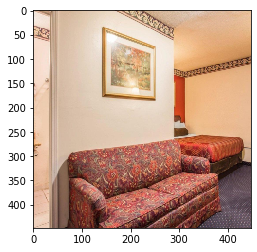

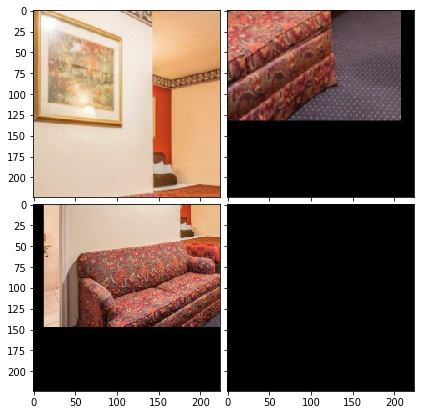

In [69]:
plot_attention(3, crops_c1, crops_c2, (2,1), (2,3))

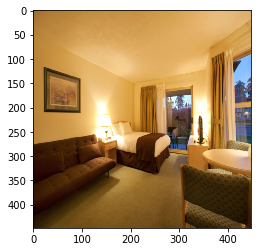

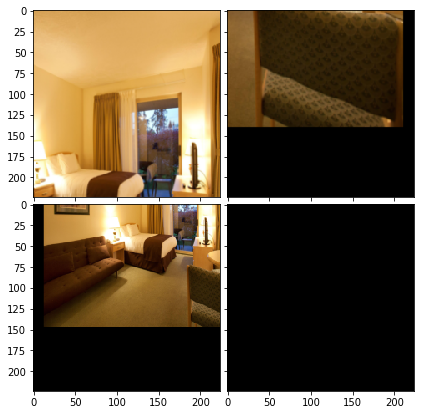

In [70]:
plot_attention(4, crops_c1, crops_c2, (2,1), (2,3))

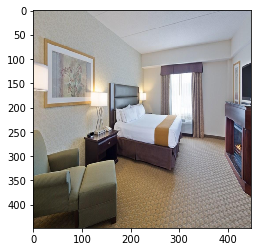

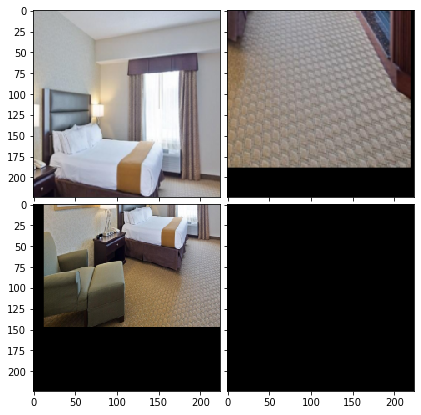

In [71]:
plot_attention(5, crops_c1, crops_c2, (2,1), (2,3))

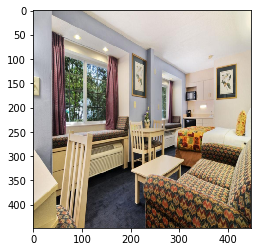

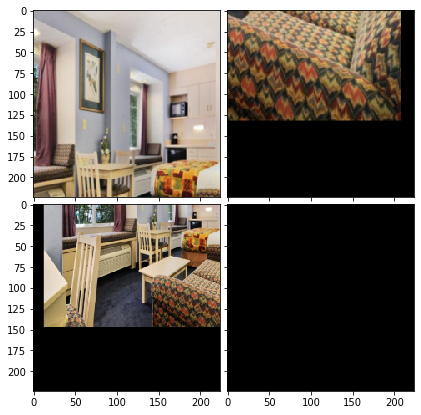

In [72]:
plot_attention(6, crops_c1, crops_c2, (2,1), (2,3))

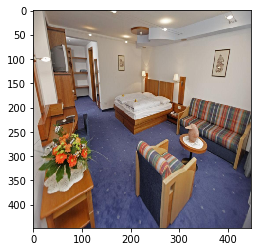

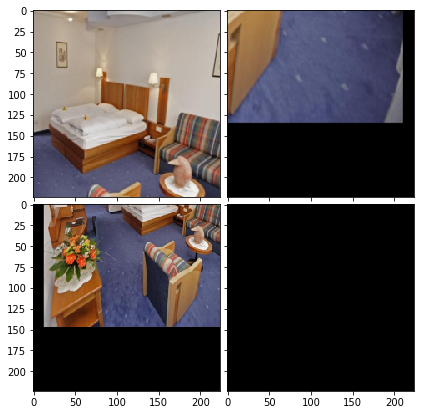

In [83]:
plot_attention(21, crops_c1, crops_c2, (2,1), (2,3))

In [93]:
test_data = get_data(False)

In [94]:
test_data.shape

(6992, 32)

In [ ]:
7000 / 32

In [6]:
import pandas as pd
import numpy as np

In [14]:
df = pd.read_pickle('test_evaluation.pkl')

unitag_indices = []
multitag_indices = []

for i in range(df.shape[0]):
    row = df.iloc[i,:31].values
    if np.sum(row) > 1:
        multitag_indices.append(i)
    else:
        unitag_indices.append(i)

unitag_df = df.iloc[unitag_indices]

unitag_df.shape

from sklearn.metrics import confusion_matrix
import seaborn as sn
import scikitplot as skplt

for k in models.keys():
    true_tags = unitag_df[k].values
    pred_tags = unitag_df['pred_'+k].values
    skplt.metrics.plot_confusion_matrix(true_tags, pred_tags.astype(np.int), normalize=True, figsize=(7,7), title=k)
    #matrix = confusion_matrix(true_tags, pred_tags)
    #print(matrix)

In [89]:
def plot_confusion_matrix(true_values, pred_values):
    neg_count = np.sum(true_values == 0)
    pos_count = np.sum(true_values == 1)
    divisor = np.array([[neg_count], [pos_count]])
    norm_matrix = matrix / divisor
    #df = pd.DataFrame(norm_matrix, ['no','si'],['no','si'])
    #plt.figure(figsize=(10,7))
    #sn.set(font_scale=1.4)
    #sn.heatmap(df, cmap='Blues',annot=True,annot_kws={"size": 16})
    

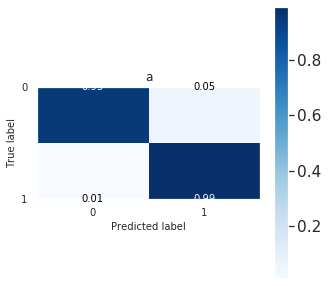

In [86]:
skplt.metrics.plot_confusion_matrix(true_tags, pred_tags, normalize=True, figsize=(5,5),s)